In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Bước 1: Import Modules

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

# Bước 2: Load bộ dữ liệu NER

Sau khi đọc tập dữ liệu, chúng ta quan sát thử 50 dòng đầu tiên như thế nào.


In [28]:
data = pd.read_csv('/content/drive/MyDrive/Ds310/ner_dataset.csv', encoding="latin1")
data = data.fillna(method="ffill")
data.head(50)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


#Visualizing 
Thông kê bộ dữ liệu:
- Số lượng từ duy nhất trong kho ngữ liệu. (Tập từ vựng, số chiều)
- Số lượng thẻ duy nhất trong tập dữ liệu. (Tập nhãn)


Bằng cách sử dụng hàm **“nunique”.**

In [29]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


Tạo một danh sách và sử dụng phương thức set() để lấy các giá trị trong cột “word” và loại bỏ giá trị trùng.\
Thêm phần đệm có tên “Endpad”.


In [30]:
#tạo tập từ vựng
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [31]:
#tạo tập nhãn tương tự như trên
# tags = ?
# num_tags = ?
tags = list(set(data["Tag"].values))
num_tags = len(tags)

# Bước 3: Lấy các câu và các thẻ tương ứng

In [32]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
  

In [33]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [34]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

# Bước 4: Ánh xạ giữa các câu và chỉ mục
Chúng ta có thể thấy rằng mỗi từ được gán cho một thẻ duy nhất. Chúng tôi có thể truy xuất những từ này bằng cách sử dụng các chỉ số của chúng và tra cứu chúng trong từ điển và trả về các khóa tương ứng.


In [35]:
word2idx = {w:  i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [36]:
#word2idx
word2idx["ENDPAD"]
tag2idx 

{'I-nat': 0,
 'B-tim': 1,
 'I-per': 2,
 'I-geo': 3,
 'B-nat': 4,
 'I-eve': 5,
 'I-gpe': 6,
 'B-art': 7,
 'B-gpe': 8,
 'I-art': 9,
 'B-eve': 10,
 'I-org': 11,
 'O': 12,
 'I-tim': 13,
 'B-per': 14,
 'B-org': 15,
 'B-geo': 16}

#Bước 5: Padding  đầu vào và cắt dữ liệu thành tập Train/Test\
Trong trục X, có thể thấy độ dài an toàn của câu là khoảng 50.

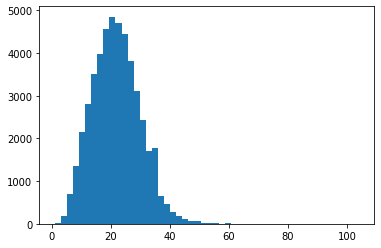

In [37]:
#vẽ biểu đồ thể hiện phân bố chiều dài của câu trong tập dữ liệu.
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

- Sử dụng hàm pad_sequence() cho padding
- X sẽ là một đại diện bằng số cho các từ. (sử dụng word2idx)
- ‘Post’ chỉ là một giá trị của đối số đệm ở cuối câu.
- X,y là vector

In [38]:
#ánh xạ từ trong câu và nhãn về index của nó
from tensorflow.keras.preprocessing.sequence import pad_sequences
#đặt max length cho phù hợp
# max_len = ?
max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

#tương tự với nhãn
# y = ?

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])




In [39]:
print(X[0])
print(y[0])

[21379  1063 18697 25174 13963 13102 30089  8301 25294   781  7916  7591
 28514 17032   219   781  2701  1063 23306 10781 28045 23606 31608 20048
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178]
[12 12 12 12 12 12 16 12 12 12 12 12 16 12 12 12 12 12  8 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12]


- test_size = 0.2 có nghĩa là 80% dữ liệu chia cho tập huấn luyện và 20% còn lại cho tập kiểm tra.

In [40]:
from sklearn.model_selection import train_test_split 
# x_train, x_test, y_train, y_test = ?
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Bước 6: Xây dựng Mô hình LSTM hai chiều (bi-LSTM)


In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

Bản tóm tắt cho thấy rằng chúng ta có hơn 1,8 triệu tham số cần được huấn luyện.

In [42]:
model = Sequential() #Yêu cầu khỏi tạo mạng LSTM 1 chiều

# Input
model.add(Input(shape=(max_len,)))
# Embedding
model.add(Embedding(input_dim=num_words, output_dim=50, input_length=50))
# SpatialDropout1D
model.add(SpatialDropout1D(0.1))
# LSTM
model.add(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))
# TimeDistributed
model.add(TimeDistributed(Dense(num_tags, activation='softmax')))

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 50)            1758950   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 50, 50)           0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 50, 100)           60400     
                                                                 
 time_distributed_1 (TimeDis  (None, 50, 17)           1717      
 tributed)                                                       
                                                                 
Total params: 1,821,067
Trainable params: 1,821,067
Non-trainable params: 0
_________________________________________________________________


- Sử dụng trình tối ưu hoá "adam"
- sparce_categorical_crossentropy làm hàm mất mát
- Ma trận mà chúng ta sẽ quan tâm là ma trận độ chính xác.

In [43]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

#Bước7: Huấn luyện Model

- Để bắt đầu huấn luyện là gọi model.fit ()
- Có thể tăng kích thước batch_size nếu bạn có GPU có kích thước bộ nhớ lớn.



In [19]:
 
# Các bạn nhớ là phải lưu mô hình khi train (có nhắc lại yêu cầu ở cuối) 
import time
start_time = time.time()

history = model.fit(
    x=x_train,
    y=y_train,
    #validation_data=(x_test,y_test),
    validation_split= 0.1,
    batch_size= 32, 
    epochs=1,
    verbose=1
)
print("[{}] Completed!".format(time.time() - start_time))

1080/1080 [==============================] - 141s 127ms/step - loss: 0.2439 - accuracy: 0.9486 - val_loss: 0.1095 - val_accuracy: 0.9718
[145.75064635276794] Completed!


# Bước8: Đánh giá mô hình NER



In [20]:
model.evaluate(x_test, y_test)

300/300 [==============================] - 6s 20ms/step - loss: 0.1128 - accuracy: 0.9715


[0.11278004199266434, 0.9715304374694824]

- Dự đoán

In [21]:
#i = np.random.randint(0, x_test.shape[0]) #659
print(x_test[1])
i =10
p = model.predict(np.array([x_test[i]]))

p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

[15797 29524 18067  9094 10526  4899 33826  6171 20129 13386  5867 17381
  9474  7521 34354  4899 21063 29045  7521  9474  6393 24823 34129  7359
  8937 23980 20048 24823 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178]
1/1 [==============================] - 0s 305ms/step
Word           True 	 Pred

------------------------------
My             O	O
unfounded      O	O
al-Shaalan     O	O
El~Fasher      O	O
infringe       O	O
Colombant      B-geo	B-geo
Judicial       O	O
Horizons       O	O
Judicial       O	O
Rodrigo        B-geo	B-geo
7.9            O	O
Kula           O	O
05-Mar         O	O
collaborators  O	O
Csongrad       O	O
second-seeded  O	O
Branco         O	O
suburban       O	O
incident       O	O
winds          O	O
stopping       O	O
That           O	O
landholders    O	O
landholders    O	O
landholders    O	O
landholders    O	O
landholders    O	O
landholders    O	O
landholders    O	O
landholders    

In [22]:
# hoàn thành yêu cầu trong file thực hành tương ứng cho câu 1 và 2.
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=-1)

300/300 [==============================] - 5s 18ms/step


In [23]:
from sklearn.metrics import f1_score, classification_report
print('micro:', f1_score(y_test.flatten(), y_pred.flatten(), average='micro')*100)
print('macro:', f1_score(y_test.flatten(), y_pred.flatten(), average='macro')*100)

micro: 97.15304420350292
macro: 37.09279220801931


In [24]:
print(classification_report(y_test.flatten(), y_pred.flatten(), target_names = tags))
print('Accuracy:', model.evaluate(x_test, y_test)[1]*100)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       I-nat       0.00      0.00      0.00        12
       B-tim       0.80      0.70      0.75      4102
       I-per       0.58      0.85      0.69      3424
       I-geo       0.67      0.57      0.61      1449
       B-nat       0.00      0.00      0.00        38
       I-eve       0.00      0.00      0.00        73
       I-gpe       0.00      0.00      0.00        33
       B-art       0.00      0.00      0.00        96
       B-gpe       0.71      0.73      0.72      3173
       I-art       0.00      0.00      0.00        86
       B-eve       0.00      0.00      0.00        79
       I-org       0.54      0.38      0.45      3254
           O       0.99      1.00      0.99    447795
       I-tim       0.89      0.23      0.37      1339
       B-per       0.68      0.51      0.58      3359
       B-org       0.63      0.29      0.40      3908
       B-geo       0.67      0.83      0.74      7380

    accuracy              

# Bước 9: lưu model

Các bạn lưu lại model đã lưu và bộ trong số model

In [25]:
from keras.models import save_model
save_model(model, filepath='/content/drive/MyDrive/Ds310/Buổi 2/LSTM_cau_1_BTTH2.h5')